In [1]:
!rm Task09_Spleen.tar
!gdown --id 1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE

rm: cannot remove 'Task09_Spleen.tar': No such file or directory
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE
To: /content/Task09_Spleen.tar
100% 1.61G/1.61G [00:16<00:00, 96.8MB/s]


In [2]:
%%capture
!tar -xvf Task09_Spleen.tar
!pip install SimpleITK

In [1]:
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch 
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import os 
import numpy as np
import cv2
import SimpleITK as sitk

# ----------------------------------------------------------------

def getNii(path):

    data = sitk.ReadImage(path)
    return sitk.GetArrayFromImage(data)

# ----------------------------------------------------------------

def get_x_y():

    IMAGES_PATH='Task09_Spleen/imagesTr/'
    LABELS_PATH='Task09_Spleen/labelsTr/'

    tr_image_paths = np.sort(os.listdir(IMAGES_PATH))[-5:]
    tr_labels_paths = np.sort(os.listdir(LABELS_PATH))[-5:]

    tr_x = []
    tr_y = []

    d = 0

    for image_name, label_name in zip(tr_image_paths, tr_labels_paths):
        
        if image_name[0] == '.': continue

        image_path = os.path.join(IMAGES_PATH, image_name)
        label_path = os.path.join(LABELS_PATH, label_name)

        image = getNii(image_path)
        label = getNii(label_path)

        for image_slice in image:
            image_rgb = cv2.cvtColor(image_slice,cv2.COLOR_GRAY2RGB).reshape((512,512,3))
            image_rgb = (image_rgb - np.min(image_rgb))/(np.max(image_rgb) - np.min(image_rgb))
            tr_x.append(image_rgb)

        d += label.shape[0]
        tr_y.append(label)

    tr_x = np.array(tr_x).reshape((d, 512 ,512, 3))
    tr_y = np.concatenate(tr_y).reshape((d, 512, 512))

    return tr_x, tr_y

In [2]:
x, y = get_x_y()

X = np.array(x, np.float32)
Y = np.array(y, np.float32)

print(f'Loaded {len(X)} images')
print(f'Loaded {len(Y)} masks')

Loaded 313 images
Loaded 313 masks


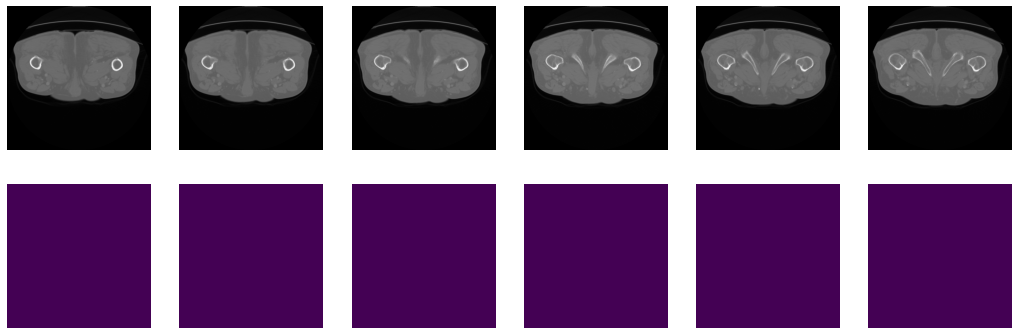

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# show examples of images

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i].reshape((512,512,3)))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i].reshape((512,512)))

plt.show();

In [4]:
# split data for training/testing/validation

ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [(len(X)//4)*3])

In [5]:
from torch.utils.data import DataLoader

# make data loaders

batch_size = 8

data_tr = DataLoader(
    list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
    batch_size=batch_size, shuffle=True)

data_val = DataLoader(
    list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
    batch_size=batch_size, shuffle=True)

# data_ts = DataLoader(
#     list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
#     batch_size=batch_size, shuffle=True)

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,10)

In [8]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(128)
        self.dec_conv02 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(64)
        self.dec_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(32)
        self.dec_conv22 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3, foo = self.pool0(e2)

        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6, foo = self.pool1(e5)
        
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9, foo = self.pool2(e8)

        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12, foo = self.pool3(e11)
        
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))

        # decoder
        d1 = self.upsample0(b)
        d2 = F.relu(self.bnorm_01(self.dec_conv01(d1)))
        d3 = F.relu(self.bnorm_02(self.dec_conv02(d2)))

        d4 = self.upsample1(d3)
        d5 = F.relu(self.bnorm_11(self.dec_conv11(d4)))
        d6 = F.relu(self.bnorm_12(self.dec_conv12(d5)))
        
        d7 = self.upsample2(d6)
        d8 = F.relu(self.bnorm_21(self.dec_conv21(d7)))
        d9 = F.relu(self.bnorm_22(self.dec_conv22(d8)))
        d10 = self.upsample3(d9)
        d11 = F.sigmoid(self.dec_conv3(d10))

        return d11   # no activation

In [9]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch.to(device)
            Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch.to(device))
            loss = loss_fn(Y_pred,Y_batch.to(device)) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval() # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('True maks')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [10]:
model = SegNet().to(device)

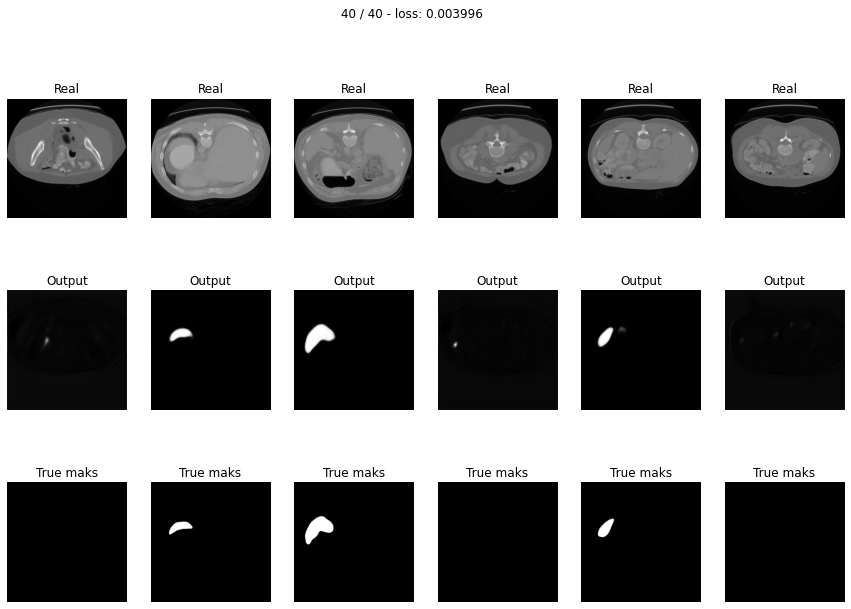

In [11]:
bce_loss = nn.BCELoss()

max_epochs = 40
optimization = optim.Adam(model.parameters(), lr=0.0002)
train(model, optimization, bce_loss, max_epochs, data_tr, data_val)